In [4]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
from session_gen import SessionGenerator
import os
from IPython.core.display import display,HTML

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


In [5]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,dryer,0.0,12505451713,False
1,2,dryer,1.0,84691226727,True
2,2,dryer,2.0,883049066905,False
3,2,dryer,3.0,14381196320,False
4,2,dryer,4.0,74108056764,False
...,...,...,...,...,...
149995,55001,blue ray,25.0,22265004517,False
149996,55001,blue ray,26.0,885170038875,False
149997,55001,blue ray,27.0,786936817232,False
149998,55001,blue ray,28.0,600603132872,False


In [6]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())

products

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",24543750949,X-Men: First Class - Widescreen Dubbed Subtitl...,\N,\N,\N,13b0b350-8832-46df-9aea-a8991af6534b,1684550853664440322
1,"<img height=""100"" src=""../data/retrotech/image...",803238004525,Headphones - CD,Suicide Squeeze,\N,\N,c2490d46-dd98-4b55-a594-1e064893d3dd,1684550853904564231
2,"<img height=""100"" src=""../data/retrotech/image...",883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
3,"<img height=""100"" src=""../data/retrotech/image...",843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
4,"<img height=""100"" src=""../data/retrotech/image...",600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
...,...,...,...,...,...,...,...,...
307,"<img height=""100"" src=""../data/retrotech/image...",97361455044,Thor (2011) (2 Disc) (W/Dvd) - Widescreen Dubb...,\N,\N,\N,1d19f238-5eac-4884-8866-b1cd84a2199c,1684550857352282117
308,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
309,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates Of The Caribbean: On Stranger Tides (3...,\N,\N,\N,94ac7204-2099-472c-b2ab-d75ec63cb613,1684550857360670727
310,"<img height=""100"" src=""../data/retrotech/image...",24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


# Code Omitted (repeat Listing 11.13 on sparse query)

We repeat COEC table computation for Blue Ray

In [7]:
QUERY='blue ray'
query_sessions = sessions[sessions['query'] == QUERY]
# Simulate a rare query by slicing out some data
query_sessions = query_sessions[query_sessions['sess_id'] < 50020]

In [816]:
QUERY='blue ray'
query_sessions = sessions[sessions['query'] == QUERY]
# Simulate a rare query by slicing out some data
query_sessions = query_sessions[query_sessions['sess_id'] < 50020]

sessions_by_doc_and_rank = query_sessions.groupby(['doc_id', 'rank'])

clicks_at_each_rank = sessions_by_doc_and_rank['clicked'].sum()
appears_at_each_rank = sessions_by_doc_and_rank['sess_id'].nunique()

# Record clicks at the rank, appearances at that rank, and CTR
coecs_blue_ray = clicks_at_each_rank.to_frame()
coecs_blue_ray['appears'] = appears_at_each_rank
coecs_blue_ray['ctr'] = clicks_at_each_rank / appears_at_each_rank

# Store global_ctr at each rank
coecs_blue_ray = coecs_blue_ray.reset_index().set_index('rank')
coecs_blue_ray['global_ctr'] = global_ctrs
coecs_blue_ray = coecs_blue_ray.reset_index().set_index(['doc_id', 'rank'])

# Compute COECS
coecs_blue_ray['coec'] = coecs_blue_ray['ctr'] / coecs_blue_ray['global_ctr']

BLU_RAY_PLAYER_UPC=885170033412

coecs_blue_ray.loc[BLU_RAY_PLAYER_UPC]

,clicked,appears,ctr,global_ctr,coec
rank,,,,,
4.0,4.0,18,0.222222,0.056255,3.950298


In [817]:
BLU_RAY_PLAYER_UPC=813774010904

coecs_blue_ray.loc[BLU_RAY_PLAYER_UPC]

,clicked,appears,ctr,global_ctr,coec
rank,,,,,
0.0,0.0,1,0.000000,0.249727,0.000000
13.0,0.0,1,0.000000,0.014509,0.000000
20.0,1.0,12,0.083333,0.006236,13.362488
24.0,0.0,1,0.000000,0.005309,0.000000
25.0,0.0,1,0.000000,0.004364,0.000000
26.0,0.0,1,0.000000,0.005055,0.000000
27.0,0.0,1,0.000000,0.004691,0.000000


# Figure 10.10 

Beta distribution for CTR=0.125

a=2.5 b=17.5


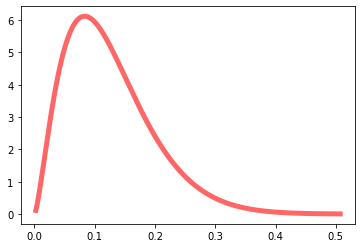

In [818]:
# Fit a beta prior to global_ctr
from scipy.stats import beta

prior_ctr = 0.125

prior_weight = 20
a=prior_ctr*prior_weight; b=(1-prior_ctr)*prior_weight
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 10.11

Adding clicks to the beta distribution

a=3.5 b=17.5


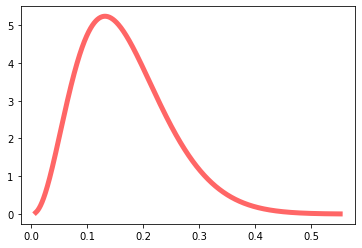

In [819]:
# Fit a beta prior to global_ctr
a+=1
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

In [820]:
prior_weight=1000
coecs_dryer['prior_a'] = coecs_dryer['global_ctr']*prior_weight
coecs_dryer['prior_b'] = (1-coecs_dryer['global_ctr'])*prior_weight

coecs_dryer.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec_posn,coec,prior_a,prior_b
rank,,,,,,,,
0.0,23.0,57,0.403509,0.249727,1.615798,1.502744,249.727273,750.272727
1.0,7.0,44,0.159091,0.142673,1.115076,1.502744,142.672727,857.327273
2.0,13.0,47,0.276596,0.084218,3.284276,1.502744,84.218182,915.781818
3.0,2.0,59,0.033898,0.063073,0.537448,1.502744,63.072727,936.927273
4.0,3.0,50,0.060000,0.056255,1.066580,1.502744,56.254545,943.745455
5.0,6.0,60,0.100000,0.042255,2.366609,1.502744,42.254545,957.745455
6.0,4.0,66,0.060606,0.033236,1.823487,1.502744,33.236364,966.763636
7.0,190.0,3990,0.047619,0.038000,1.253133,1.502744,38.000000,962.000000
8.0,4.0,55,0.072727,0.020964,3.469211,1.502744,20.963636,979.036364


In [821]:
# Update using existing session data
coecs_dryer['posterior_a'] = coecs_dryer['prior_a'] + coecs_dryer['clicked']
coecs_dryer['posterior_b'] = coecs_dryer['prior_b'] + (coecs_dryer['appears'] - coecs_dryer['clicked'])

ALBUM_UPC=665331101927
coecs_dryer.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec_posn,coec,prior_a,prior_b,posterior_a,posterior_b
rank,,,,,,,,,,
0.0,23.0,57,0.403509,0.249727,1.615798,1.502744,249.727273,750.272727,272.727273,784.272727
1.0,7.0,44,0.159091,0.142673,1.115076,1.502744,142.672727,857.327273,149.672727,894.327273
2.0,13.0,47,0.276596,0.084218,3.284276,1.502744,84.218182,915.781818,97.218182,949.781818
3.0,2.0,59,0.033898,0.063073,0.537448,1.502744,63.072727,936.927273,65.072727,993.927273
4.0,3.0,50,0.060000,0.056255,1.066580,1.502744,56.254545,943.745455,59.254545,990.745455
5.0,6.0,60,0.100000,0.042255,2.366609,1.502744,42.254545,957.745455,48.254545,1011.745455
6.0,4.0,66,0.060606,0.033236,1.823487,1.502744,33.236364,966.763636,37.236364,1028.763636
7.0,190.0,3990,0.047619,0.038000,1.253133,1.502744,38.000000,962.000000,228.000000,4762.000000
8.0,4.0,55,0.072727,0.020964,3.469211,1.502744,20.963636,979.036364,24.963636,1030.036364


In [822]:
coecs_dryer['new_ctr'] = coecs_dryer['posterior_a'] / (coecs_dryer['posterior_a'] + coecs_dryer['posterior_b'])
coecs_dryer['new_coec'] = coecs_dryer['new_ctr'] / coecs_dryer['global_ctr']

ALBUM_UPC=665331101927
coecs_dryer.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec_posn,coec,prior_a,prior_b,posterior_a,posterior_b,new_ctr,new_coec
rank,,,,,,,,,,,,
0.0,23.0,57,0.403509,0.249727,1.615798,1.502744,249.727273,750.272727,272.727273,784.272727,0.258020,1.033208
1.0,7.0,44,0.159091,0.142673,1.115076,1.502744,142.672727,857.327273,149.672727,894.327273,0.143365,1.004850
2.0,13.0,47,0.276596,0.084218,3.284276,1.502744,84.218182,915.781818,97.218182,949.781818,0.092854,1.102542
3.0,2.0,59,0.033898,0.063073,0.537448,1.502744,63.072727,936.927273,65.072727,993.927273,0.061447,0.974230
4.0,3.0,50,0.060000,0.056255,1.066580,1.502744,56.254545,943.745455,59.254545,990.745455,0.056433,1.003170
5.0,6.0,60,0.100000,0.042255,2.366609,1.502744,42.254545,957.745455,48.254545,1011.745455,0.045523,1.077355
6.0,4.0,66,0.060606,0.033236,1.823487,1.502744,33.236364,966.763636,37.236364,1028.763636,0.034931,1.050985
7.0,190.0,3990,0.047619,0.038000,1.253133,1.502744,38.000000,962.000000,228.000000,4762.000000,0.045691,1.202405
8.0,4.0,55,0.072727,0.020964,3.469211,1.502744,20.963636,979.036364,24.963636,1030.036364,0.023662,1.128727


In [830]:
coecs_dryer.loc[74108096487]

,clicked,appears,ctr,global_ctr,coec_posn,coec,prior_a,prior_b,posterior_a,posterior_b,new_ctr,new_coec,w_new_coec
rank,,,,,,,,,,,,,
0.0,25.0,53,0.471698,0.249727,1.888853,1.502744,249.727273,750.272727,274.727273,778.272727,0.260900,1.044738,0.011074
1.0,13.0,51,0.254902,0.142673,1.786620,1.502744,142.672727,857.327273,155.672727,895.327273,0.148119,1.038171,0.010589
2.0,6.0,46,0.130435,0.084218,1.548772,1.502744,84.218182,915.781818,90.218182,955.781818,0.086251,1.024133,0.009422
3.0,11.0,44,0.250000,0.063073,3.963678,1.502744,63.072727,936.927273,74.072727,969.927273,0.070951,1.124906,0.009899
4.0,6.0,48,0.125000,0.056255,2.222043,1.502744,56.254545,943.745455,62.254545,985.745455,0.059403,1.055971,0.010137
5.0,2.0,50,0.040000,0.042255,0.946644,1.502744,42.254545,957.745455,44.254545,1005.745455,0.042147,0.997459,0.009975
6.0,6.0,61,0.098361,0.033236,2.959429,1.502744,33.236364,966.763636,39.236364,1021.763636,0.036981,1.112653,0.013574
7.0,0.0,61,0.000000,0.038000,0.000000,1.502744,38.000000,962.000000,38.000000,1023.000000,0.035815,0.942507,0.011499
8.0,0.0,54,0.000000,0.020964,0.000000,1.502744,20.963636,979.036364,20.963636,1033.036364,0.019890,0.948767,0.010247


In [824]:
num_sessions = coecs_dryer.groupby('doc_id')['appears'].sum()

weight = coecs_dryer['appears'] / num_sessions
coecs_dryer['w_new_coec'] = weight * coecs_dryer['new_coec']

ALBUM_UPC=665331101927
coecs_dryer.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec_posn,coec,prior_a,prior_b,posterior_a,posterior_b,new_ctr,new_coec,w_new_coec
rank,,,,,,,,,,,,,
0.0,23.0,57,0.403509,0.249727,1.615798,1.502744,249.727273,750.272727,272.727273,784.272727,0.258020,1.033208,0.011779
1.0,7.0,44,0.159091,0.142673,1.115076,1.502744,142.672727,857.327273,149.672727,894.327273,0.143365,1.004850,0.008843
2.0,13.0,47,0.276596,0.084218,3.284276,1.502744,84.218182,915.781818,97.218182,949.781818,0.092854,1.102542,0.010364
3.0,2.0,59,0.033898,0.063073,0.537448,1.502744,63.072727,936.927273,65.072727,993.927273,0.061447,0.974230,0.011496
4.0,3.0,50,0.060000,0.056255,1.066580,1.502744,56.254545,943.745455,59.254545,990.745455,0.056433,1.003170,0.010032
5.0,6.0,60,0.100000,0.042255,2.366609,1.502744,42.254545,957.745455,48.254545,1011.745455,0.045523,1.077355,0.012928
6.0,4.0,66,0.060606,0.033236,1.823487,1.502744,33.236364,966.763636,37.236364,1028.763636,0.034931,1.050985,0.013873
7.0,190.0,3990,0.047619,0.038000,1.253133,1.502744,38.000000,962.000000,228.000000,4762.000000,0.045691,1.202405,0.959519
8.0,4.0,55,0.072727,0.020964,3.469211,1.502744,20.963636,979.036364,24.963636,1030.036364,0.023662,1.128727,0.012416


In [828]:

dryer_relevance = coecs_dryer.groupby('doc_id')['w_new_coec'].sum()
dryer_relevance.sort_values(ascending=False)

doc_id
74108096487     1.786860
48231011396     1.740926
74108007469     1.727027
12505525766     1.714098
856751002097    1.586620
48231011402     1.512770
12505527456     1.481955
14381196320     1.467447
783722274422    1.444690
36725561977     1.389386
36725578241     1.273534
84691226703     1.264979
84691226727     1.208969
77283045400     1.196662
665331101927    1.174459
36172950027     1.069629
74108056764     1.029326
883049066905    0.849346
883929085118    0.611341
12505451713     0.567607
Name: w_new_coec, dtype: float64

In [829]:
render(dryer_relevance.sort_values(ascending=False).to_frame(), grade_col='w_new_coec', label=f"Confidence adjusted COEC judgments for q={QUERY}")

,w_new_coec,image,upc,name,shortDescription
0,1.786860,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
1,1.740926,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
2,1.727027,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
3,1.714098,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
4,1.586620,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
5,1.512770,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
6,1.481955,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"
7,1.467447,,14381196320,The Mind Snatchers - DVD,\N
8,1.444690,,783722274422,The Independent - Widescreen Subtitle - DVD,\N
9,1.389386,,36725561977,Samsung - 3.5 Cu. Ft. 6-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedSoft dial touch pad controls; 6 cycles; delay-start; child lock; Vibration Reduction Technology


# Listing 11.14

Computing a weighted COEC

In [751]:
num_sessions = coecs_table.groupby('doc_id')['appears'].sum()

# Compute number of sessions
coecs_table = coecs_table.reset_index().set_index('doc_id')
coecs_table['num_sessions'] = num_sessions
coecs_table = coecs_table.reset_index().set_index(['doc_id', 'rank'])

# COEC weight in the weighted average
coecs_table['coec_weight'] = coecs_table['appears'] / coecs_table['num_sessions']
coecs_table['weighted_coec'] = coecs_table['coec_weight'] * coecs_table['coec']


coecs_table.loc[ALBUM_UPC]

KeyError: 665331101927

In [716]:
# Mark the last click on each query's session
QUERY='transformers dark of the moon'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['orig_grade'] = sdbn['clicked'] / sdbn['examined']

sdbn.sort_values('orig_grade', ascending=False)

,clicked,examined,orig_grade
doc_id,,,
97360810042,412.0,642.0,0.641745
400192926087,62.0,129.0,0.480620
97363560449,96.0,243.0,0.395062
97363532149,42.0,130.0,0.323077
93624956037,41.0,154.0,0.266234
47875842328,367.0,1531.0,0.239713
47875841420,217.0,960.0,0.226042
25192107191,176.0,1082.0,0.162662
786936817218,118.0,777.0,0.151866


In [717]:
PRIOR_GRADE=0.4
PRIOR_WEIGHT=40
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

POSTERIOR_WEIGHT=1
sdbn['posterior_a'] = sdbn['prior_a'] + sdbn['clicked']*POSTERIOR_WEIGHT
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])*POSTERIOR_WEIGHT

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

,clicked,examined,orig_grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
97360810042,412.0,642.0,0.641745,16.0,24.0,428.0,254.0,0.627566
400192926087,62.0,129.0,0.480620,16.0,24.0,78.0,91.0,0.461538
97363560449,96.0,243.0,0.395062,16.0,24.0,112.0,171.0,0.395760
97363532149,42.0,130.0,0.323077,16.0,24.0,58.0,112.0,0.341176
93624956037,41.0,154.0,0.266234,16.0,24.0,57.0,137.0,0.293814
47875842328,367.0,1531.0,0.239713,16.0,24.0,383.0,1188.0,0.243794
47875841420,217.0,960.0,0.226042,16.0,24.0,233.0,767.0,0.233000
47875841369,37.0,251.0,0.147410,16.0,24.0,53.0,238.0,0.182131
36725235564,41.0,277.0,0.148014,16.0,24.0,57.0,260.0,0.179811




# Listing 11.15

Finishing the weighted COEC judgments for `dryer`

In [541]:
coecs = coecs_table.groupby('doc_id')['weighted_coec'].sum()
coecs.sort_values(ascending=False)

doc_id
12505525766     2.175324
48231011396     2.152083
74108096487     2.122297
74108007469     2.114322
856751002097    1.906000
48231011402     1.764284
14381196320     1.727134
783722274422    1.724256
12505527456     1.641824
36725578241     1.510961
36725561977     1.495719
665331101927    1.469152
84691226703     1.453686
84691226727     1.361376
77283045400     1.249571
36172950027     1.053617
74108056764     0.982192
883049066905    0.856341
883929085118    0.405863
12505451713     0.340076
Name: weighted_coec, dtype: float64

In [546]:
render(coecs.sort_values(ascending=False).to_frame(), grade_col='weighted_coec', label=f"Weighted COEC for {QUERY}")

,weighted_coec,image,upc,name,shortDescription
0,2.175324,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
1,2.152083,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
2,2.122297,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
3,2.114322,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
4,1.906000,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
5,1.764284,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
6,1.727134,,14381196320,The Mind Snatchers - DVD,\N
7,1.724256,,783722274422,The Independent - Widescreen Subtitle - DVD,\N
8,1.641824,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"
9,1.510961,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package


In [548]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]

sessions_by_doc_and_rank = query_sessions.groupby(['doc_id', 'rank'])

clicks_at_each_rank = sessions_by_doc_and_rank['clicked'].sum()
appears_at_each_rank = sessions_by_doc_and_rank['sess_id'].nunique()

# Record clicks at the rank, appearances at that rank, and CTR
coecs_table = clicks_at_each_rank.to_frame()
coecs_table['appears'] = appears_at_each_rank
coecs_table['ctr'] = clicks_at_each_rank / appears_at_each_rank

# Store global_ctr at each rank
coecs_table = coecs_table.reset_index().set_index('rank')
coecs_table['global_ctr'] = global_ctrs
coecs_table = coecs_table.reset_index().set_index(['doc_id', 'rank'])

# Compute COECS
coecs_table['coec'] = coecs_table['ctr'] / coecs_table['global_ctr']


num_sessions = coecs_table.groupby('doc_id')['appears'].sum()

# Compute number of sessions
coecs_table = coecs_table.reset_index().set_index('doc_id')
coecs_table['num_sessions'] = num_sessions
coecs_table = coecs_table.reset_index().set_index(['doc_id', 'rank'])

# COEC weight in the weighted average
coecs_table['coec_weight'] = coecs_table['appears'] / coecs_table['num_sessions']
coecs_table['weighted_coec'] = coecs_table['coec_weight'] * coecs_table['coec']

coecs = coecs_table.groupby('doc_id')['weighted_coec'].sum()
coecs = coecs.sort_values(ascending=False)

render(coecs.sort_values(ascending=False).to_frame(), grade_col='weighted_coec', label=f"Weighted COEC for {QUERY}")

,weighted_coec,image,upc,name,shortDescription
0,2.010651,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
1,0.858234,,97363560449,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
2,0.709636,,400192926087,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
3,0.707582,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
4,0.449639,,47875841406,Transformers: Dark of the Moon Autobots - Nintendo DS,Transform into an epic hero or a vehicular villain
5,0.434129,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N
6,0.413437,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
7,0.385745,,36725235564,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",\N
8,0.372154,,93624956037,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
9,0.360019,,47875841369,Transformers: Dark of the Moon - PlayStation 3,Transform into an epic hero or a vehicular villain


In [647]:
QUERY='dryer'
query_sessions = sessions[sessions['query'] == QUERY]
query_sessions = query_sessions[query_sessions['sess_id'] < 10]
query_sessions

sessions_by_doc_and_rank = query_sessions.groupby(['doc_id', 'rank'])

clicks_at_each_rank = sessions_by_doc_and_rank['clicked'].sum()
appears_at_each_rank = sessions_by_doc_and_rank['sess_id'].nunique()

# Record clicks at the rank, appearances at that rank, and CTR
coecs_table = clicks_at_each_rank.to_frame()
coecs_table['appears'] = appears_at_each_rank
coecs_table['ctr'] = clicks_at_each_rank / appears_at_each_rank

# Store global_ctr at each rank
coecs_table = coecs_table.reset_index().set_index('rank')
coecs_table['global_ctr'] = global_ctrs
coecs_table = coecs_table.reset_index().set_index(['doc_id', 'rank'])

# Compute COECS
coecs_table['coec'] = coecs_table['ctr'] / coecs_table['global_ctr']

ALBUM_UPC=665331101927
coecs_table.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec
rank,,,,,
7.0,1.0,8,0.125,0.038,3.289474


In [659]:
#beta_priors = global_ctrs.rename('global_ctr').to_frame()
prior_weight=20
coecs_table['prior_a'] = coecs_table['global_ctr']*prior_weight
coecs_table['prior_b'] = (1-coecs_table['global_ctr'])*prior_weight

coecs_table

clicked  appears       ctr  global_ctr       coec  \
doc_id       rank                                                      
12505451713  0.0       0.0        7  0.000000    0.249727   0.000000   
             19.0      0.0        1  0.000000    0.008145   0.000000   
12505525766  3.0       1.0        1  1.000000    0.063073  15.854713   
             11.0      0.0        7  0.000000    0.018582   0.000000   
12505527456  4.0       0.0        1  0.000000    0.056255   0.000000   
             8.0       0.0        1  0.000000    0.020964   0.000000   
             15.0      0.0        1  0.000000    0.010200   0.000000   
             17.0      0.0        5  0.000000    0.007891   0.000000   
14381196320  3.0       0.0        1  0.000000    0.063073   0.000000   
             8.0       1.0        6  0.166667    0.020964   7.950275   
             14.0      0.0        1  0.000000    0.012327   0.000000   
36172950027  9.0       0.0        1  0.000000    0.017364   0.000000   
             10.0      0.0        6  0.000000    0.013982   0.000000   
             18.0      0.0        1  0.000000    0.007273   0.000000   
36725561977  1.0       1.0        1  1.000000    0.142673   7.009048   
             15.0      0.0        7  0.000000    0.010200   0.000000   
36725578241  14.0      0.0        1  0.000000    0.012327   0.000000   
             16.0      0.0        7  0.000000    0.011782   0.000000   
48231011396  3.0       0.0        1  0.000000    0.063073   0.000000   
             18.0      0.0        7  0.000000    0.007273   0.000000   
48231011402  11.0      1.0        1  1.000000    0.018582  53.816047   
             12.0      1.0        7  0.142857    0.015982   8.938729   
74108007469  2.0       0.0        1  0.000000    0.084218   0.000000   
             10.0      0.0        1  0.000000    0.013982   0.000000   
             13.0      0.0        6  0.000000    0.014509   0.000000   
74108056764  3.0       0.0        1  0.000000    0.063073   0.000000   
             4.0       0.0        7  0.000000    0.056255   0.000000   
74108096487  0.0       1.0        1  1.000000    0.249727   4.004368   
             9.0       1.0        7  0.142857    0.017364   8.227375   
77283045400  5.0       0.0        7  0.000000    0.042255   0.000000   
             17.0      0.0        1  0.000000    0.007891   0.000000   
84691226703  1.0       0.0        1  0.000000    0.142673   0.000000   
             3.0       0.0        4  0.000000    0.063073   0.000000   
             6.0       0.0        1  0.000000    0.033236   0.000000   
             13.0      0.0        1  0.000000    0.014509   0.000000   
             16.0      0.0        1  0.000000    0.011782   0.000000   
84691226727  1.0       2.0        6  0.333333    0.142673   2.336349   
             2.0       0.0        1  0.000000    0.084218   0.000000   
             17.0      0.0        1  0.000000    0.007891   0.000000   
665331101927 7.0       1.0        8  0.125000    0.038000   3.289474   
783722274422 6.0       0.0        6  0.000000    0.033236   0.000000   
             12.0      0.0        1  0.000000    0.015982   0.000000   
             13.0      0.0        1  0.000000    0.014509   0.000000   
856751002097 6.0       0.0        1  0.000000    0.033236   0.000000   
             10.0      0.0        1  0.000000    0.013982   0.000000   
             19.0      0.0        6  0.000000    0.008145   0.000000   
883049066905 2.0       0.0        6  0.000000    0.084218   0.000000   
             17.0      0.0        1  0.000000    0.007891   0.000000   
             19.0      0.0        1  0.000000    0.008145   0.000000   
883929085118 5.0       0.0        1  0.000000    0.042255   0.000000   
             8.0       0.0        1  0.000000    0.020964   0.000000   
             14.0      0.0        6  0.000000    0.012327   0.000000   

                    prior_a    prior_b  posterior_a  posterior_b   new_ctr  
doc_id       rank                                    

In [660]:
# Update using existing session data

posterior_weight = 1
coecs_table['posterior_a'] = coecs_table['prior_a'] + (coecs_table['clicked'] * posterior_weight)
coecs_table['posterior_b'] = coecs_table['prior_b'] + (coecs_table['appears'] * posterior_weight)

# Recompute mean CTR using posterior a and b

coecs_table['new_ctr'] = coecs_table['posterior_a'] / (coecs_table['posterior_a'] + coecs_table['posterior_b'])

ALBUM_UPC=665331101927
coecs_table.loc[ALBUM_UPC]

,clicked,appears,ctr,global_ctr,coec,prior_a,prior_b,posterior_a,posterior_b,new_ctr
rank,,,,,,,,,,
7.0,1.0,8,0.125,0.038,3.289474,0.76,19.24,1.76,27.24,0.06069


2.5 17.5


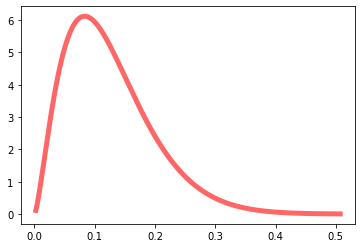

In [639]:
# Fit a beta prior to global_ctr
from scipy.stats import beta

prior_ctr = 0.125

uncertainty = 20
a=prior_ctr*uncertainty; b=(1-prior_ctr)*uncertainty
print(a,b)

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')


0.11363636363636363


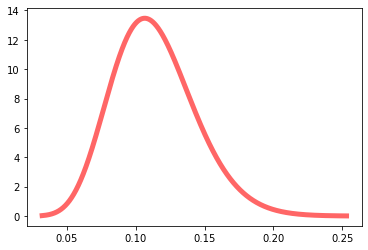

In [638]:
# Update with 1 click, 8 appearances

# Fit a beta prior to global_ctr
from scipy.stats import beta

prior = 0.125
variance = 20
a=prior*variance; b=(1-prior)*variance

post_weight=10

a+=1*post_weight
b+=8*post_weight

#shift=prior-0.5
#shift=0

expected_value = (a/(a+b))
print(expected_value)


x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

In [629]:
x

array([7.86073648e-05, 1.45908189e-04, 2.13209013e-04, ...,
       6.72884946e-01, 6.72952247e-01, 6.73019547e-01])

In [630]:
x[np.argmax(beta.pdf(x, a, b))]

0.03123888891672033

In [631]:
np.mean(beta.pdf(x, a, b))

1.485645564178549

In [633]:
beta.pdf(x, a, b)

array([1.58975125, 1.85462767, 2.03803505, ..., 0.00265242, 0.00264826,
       0.00264411])